In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import catboost
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
import seaborn as sns
import math
import pmdarima as pm

pd.options.display.max_columns = 100
pd.options.display.max_rows = 20

In [50]:
train_df = pd.read_parquet('/Users/nikitaromanov/Downloads/moscow/ИИ_прогнозирует_инфляцию/train_df.parquet')

In [51]:
target = pd.read_excel('/Users/nikitaromanov/Downloads/moscow/ИИ_прогнозирует_инфляцию/Y_train.xlsx')

In [52]:
train_df['DateObserve'] = pd.to_datetime(train_df['DateObserve'])
train_df = train_df.sort_values(by = 'DateObserve')
train_df['day'] = train_df['DateObserve'].dt.day
train_df['month'] = train_df['DateObserve'].dt.month
train_df['year'] = train_df['DateObserve'].dt.year
train_df['group'] = (train_df['day']) //  8
train_df['month+year+group'] = train_df['DateObserve'].dt.month.astype(str) + '_' + train_df['DateObserve'].dt.year.astype(str) + '_' + train_df['group'].astype(str)
train_df['month+year'] = train_df['DateObserve'].dt.month.astype(str) + '_' + train_df['DateObserve'].dt.year.astype(str)

In [53]:
train_df

,WebPriceId,DateObserve,StockStatus,CurrentPrice,day,month,year,group,month+year+group,month+year
16177094,3706473,2020-05-31 00:00:00.000,1,81.500000,31,5,2020,3,5_2020_3,5_2020
47285790,3706473,2020-05-31 00:00:00.000,1,81.500000,31,5,2020,3,5_2020_3,5_2020
15782174,3669690,2020-06-10 00:00:00.000,1,72.989998,10,6,2020,1,6_2020_1,6_2020
47085716,3669690,2020-06-10 00:00:00.000,1,72.989998,10,6,2020,1,6_2020_1,6_2020
16170000,3704641,2020-06-13 00:00:00.000,1,129.990005,13,6,2020,1,6_2020_1,6_2020
...,...,...,...,...,...,...,...,...,...,...
3759939,10704280,2022-05-31 23:59:59.707,1,465.000000,31,5,2022,3,5_2022_3,5_2022
67158402,10634731,2022-05-31 23:59:59.820,1,9369.000000,31,5,2022,3,5_2022_3,5_2022
3673456,10634731,2022-05-31 23:59:59.820,1,9369.000000,31,5,2022,3,5_2022_3,5_2022
65829580,9881141,2022-05-31 23:59:59.827,1,641.000000,31,5,2022,3,5_2022_3,5_2022


In [55]:
dates = list(train_df['month+year+group'].unique())
chosen_indexes = train_df[train_df['StockStatus'] == 1].WebPriceId.value_counts()[:35000].index

In [152]:
(train_df['WebPriceId'].value_counts() > 30).value_counts()

False    10345246
True       361567
Name: WebPriceId, dtype: int64

In [76]:
new_table = pd.DataFrame(index=dates, columns=['month+year'])

In [77]:
new_table['month+year'] = dates

In [56]:
new_table = train_df.pivot_table(index='month+year+group', values='CurrentPrice', columns='WebPriceId', aggfunc='median')[chosen_indexes]

In [57]:
new_table

WebPriceId,327872,5130755,5718255,5718254,5718256,5126210,5126211,5126207,5126213,5126208,5126212,5126209,3857827,3857794,3857805,3857833,3857842,3857832,311327,311324,3857839,3857825,3857845,3857795,3857790,3857810,3857797,3857813,3857798,3857824,3857846,3857838,3857811,3857828,3857831,3857815,3857816,3857814,2764922,3857812,3857803,2611186,4889546,3857841,2611201,2611401,2611046,4304186,2611049,2611048,...,144801,2771724,46960,3237038,140949,2684979,3953530,2935011,3964603,158336,3568833,3568829,2934945,3587665,3401933,47072,47090,3235957,7697082,3236064,2935132,2684735,3236791,144803,4704177,4425836,2687678,2935242,2687662,3251942,3064316,4592065,6208455,46620,3064839,6206818,3065460,253456,4423304,3450861,2723469,6254795,6255528,4223531,3481,3529342,8080,3252164,3713063,2723856
month+year+group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10_2020_0,7490.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,109.0,109.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,473.0,NaN,NaN,309.0,NaN,NaN,237.0,237.0,238.5,NaN,308.5,193.5,...,179.899994,NaN,384.0,NaN,NaN,1249.0,NaN,637.5,NaN,257.399994,2320.000000,2080.0,552.0,2711.5,119.900002,1669.0,1819.0,NaN,NaN,NaN,NaN,989.0,NaN,NaN,NaN,NaN,539.0,NaN,NaN,NaN,NaN,NaN,NaN,1534.0,NaN,NaN,NaN,2027.0,NaN,594.5,1345.5,NaN,NaN,NaN,NaN,12700.5,959.0,NaN,NaN,NaN
10_2020_1,999918976.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.0,104.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,506.5,NaN,NaN,294.0,NaN,NaN,227.0,227.0,218.0,NaN,282.0,176.0,...,314.899994,221.0,384.0,NaN,NaN,1199.0,NaN,711.0,NaN,324.899994,2064.000000,2189.0,585.0,3149.0,NaN,1819.0,1819.0,2304.0,NaN,135.0,313.0,949.0,2574.0,NaN,NaN,NaN,499.0,380.0,291.550003,NaN,NaN,NaN,NaN,1534.0,NaN,NaN,224.0,2030.0,NaN,618.0,1569.5,NaN,NaN,NaN,1643.0,12740.0,969.0,NaN,36579.0,NaN
10_2020_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,446.0,NaN,NaN,744.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,384.0,NaN,NaN,899.0,NaN,NaN,NaN,NaN,2087.000000,NaN,NaN,NaN,NaN,1819.0,1819.0,NaN,NaN,NaN,NaN,719.0,NaN,NaN,NaN,NaN,359.0,NaN,329.000000,1193.0,519.0,NaN,NaN,1534.0,NaN,NaN,193.0,2025.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,969.0,158.0,NaN,NaN
10_2020_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,427.5,NaN,NaN,724.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,169.899994,NaN,419.0,2768.0,NaN,999.0,NaN,655.0,NaN,329.899994,2086.000000,2080.0,539.0,NaN,NaN,1819.0,1969.0,1792.0,NaN,NaN,NaN,799.0,NaN,NaN,NaN,NaN,399.0,NaN,359.000000,1094.5,NaN,NaN,NaN,1659.0,NaN,NaN,214.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12930.0,979.0,179.0,NaN,NaN
10_2021_0,NaN,60.0,125.125,175.0,47.675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,199.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,339.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,736.5,NaN,NaN,NaN,NaN,84.900002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1947.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9_2020_3,2890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.0,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,540.0,NaN,NaN,365.5,NaN,NaN,280.0,280.0,237.0,NaN,307.0,192.0,...,NaN,33

In [61]:
new_table['month+year+group1'] = pd.to_datetime(new_table.index.str.replace('_', '-'), format='%m-%Y-%w')
new_table = new_table.sort_values(by='month+year+group1')
new_table = new_table.drop(['month+year+group1'], axis=1)
new_table

WebPriceId,327872,5130755,5718255,5718254,5718256,5126210,5126211,5126207,5126213,5126208,5126212,5126209,3857827,3857794,3857805,3857833,3857842,3857832,311327,311324,3857839,3857825,3857845,3857795,3857790,3857810,3857797,3857813,3857798,3857824,3857846,3857838,3857811,3857828,3857831,3857815,3857816,3857814,2764922,3857812,3857803,2611186,4889546,3857841,2611201,2611401,2611046,4304186,2611049,2611048,...,144801,2771724,46960,3237038,140949,2684979,3953530,2935011,3964603,158336,3568833,3568829,2934945,3587665,3401933,47072,47090,3235957,7697082,3236064,2935132,2684735,3236791,144803,4704177,4425836,2687678,2935242,2687662,3251942,3064316,4592065,6208455,46620,3064839,6206818,3065460,253456,4423304,3450861,2723469,6254795,6255528,4223531,3481,3529342,8080,3252164,3713063,2723856
month+year+group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5_2020_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6_2020_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6_2020_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,219.000000,NaN,NaN,NaN,99.900002,NaN,NaN,NaN,NaN,389.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.400002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6_2020_3,457990.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.0,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,169.899994,NaN,339.0,NaN,95.900002,NaN,NaN,NaN,NaN,314.0,NaN,NaN,NaN,NaN,NaN,1969.0,1679.0,NaN,NaN,NaN,NaN,NaN,NaN,83.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1369.0,NaN,NaN,NaN,1722.5,NaN,NaN,NaN,NaN,NaN,NaN,53310.5,NaN,954.0,NaN,NaN,NaN
7_2020_0,6990.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,309.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,319.0,NaN,NaN,NaN,NaN,NaN,NaN,1969.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1659.0,NaN,NaN,NaN,1745.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4_2022_3,NaN,57.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,289.000000,NaN,NaN,NaN,109.900002,NaN,NaN,NaN,NaN,419.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1503.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2185.0,NaN,NaN,NaN,NaN,NaN
5_2022_0,NaN,57.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [62]:
group_table = new_table.fillna(method='ffill').fillna(method='bfill')

In [63]:
medians = group_table.agg(['median']).transpose()
medians

,median
WebPriceId,
327872,9.999190e+08
5130755,5.750000e+01
5718255,1.251250e+02
5718254,1.750000e+02
5718256,4.767500e+01
...,...
3529342,1.403300e+04
8080,1.259000e+03
3252164,1.490000e+02


In [245]:
medians[(medians['median'] < 10000) & (medians['median'] > 5000)]

,median
WebPriceId,
3857825,6757.0
3857810,5105.0
3857797,8439.0
3857803,7741.0
4304186,6296.0
...,...
3805182,6312.0
4616941,5919.0
4616940,6008.0


In [64]:
groups = []
for di_min, di_max in [(0, 400), (400, 2000), (2000, 30000), (30000, 150000), (150000, math.inf)]:
    # cur_df = medians[medians['median'].isin([(prices>=di_min)&(prices<di_max)])]
    cur_df = medians[(medians['median'] >=di_min)&(medians['median']<di_max)]
    groups.append(cur_df.index.to_list())

In [65]:
for i in groups:
    print(len(i))

10560
17266
6809
265
100


In [172]:
def sort_frame(new_table):
    new_table['month+year1'] = pd.to_datetime(new_table.index.str.replace('_', '/'))
    new_table = new_table.sort_values(by='month+year1')
    new_table = new_table.drop('month+year1', axis=1)
    return new_table

In [200]:
cluster_table = new_table.transpose().fillna(0)
from sklearn import datasets
from sklearn.cluster import KMeans
model = KMeans(n_clusters=10)
model.fit(cluster_table)

all_predictions = model.predict(cluster_table)

cluster_table['class'] = all_predictions
cluster_table

month+year,5_2020,6_2020,7_2020,8_2020,9_2020,10_2020,11_2020,12_2020,1_2021,2_2021,3_2021,4_2021,5_2021,6_2021,7_2021,8_2021,9_2021,10_2021,11_2021,12_2021,1_2022,2_2022,3_2022,4_2022,5_2022,class
0,5_2020,1.0,0.046922,0.534667,0.434291,9.016032,22225.360658,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
1,5_2020,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.045455,1.0,1.0,1.043478,0.916667,1.090909,0.958333,1.0,1.0,1.0,1.0,1.0,0.956522,0
2,5_2020,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.998002,0.5005,1.0,1.0,0.001998,1000.0,0.001,1000.0,0.001,1000.0,0.5005,1.0,0
3,5_2020,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0.5,1.0,1.0,0.0,1000.0,0.0,1000.0,0.0,1000.0,0.5,1.0,0
4,5_2020,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.992659,0.501842,1.0,1.0,0.007341,271.428576,0.003684,271.428576,0.003684,271.428576,0.501842,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349996,5_2020,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.905403,0.895519,1.233341,1.0,1.135139,1.0,1.0,1.0,1.0,0.799995,1.0,1.354177,1.0,1.23517,1.156586,0
349997,5_2020,1.0,1.0,1.0,1.052633,0.749994,1.333344,1.0,1.125003,0.83333,1.0,1.0,1.0,1.226673,1.0,1.0,1.043479,1.0,0.749995,1.333343,1.0,0.729161,1.0,1.371439,0.874997,0
349998,5_2020,1.0,1.0,1.0,1.428571,0.52497,0.885753,1.085946,0.990181,0.97491,1.0,1.107721,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.925987,1.0,1.0,0
349999,5_2020,1.0,1.0,1.0,1.0,1.0,0.78513,1.298699,0.770002,1.597397,0.626018,1.597397,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.159231,1.0,0


In [201]:
cluster_table['class'].value_counts()

0    349925
8        29
9        23
5        15
4         4
3         1
6         1
2         1
1         1
7         1
Name: class, dtype: int64

In [66]:
month_change = np.exp(np.log((new_table.fillna(method='ffill').fillna(method='bfill').pct_change()+1)))

/Users/nikitaromanov/Library/Python/3.8/lib/python/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [67]:
month_change

WebPriceId,327872,5130755,5718255,5718254,5718256,5126210,5126211,5126207,5126213,5126208,5126212,5126209,3857827,3857794,3857805,3857833,3857842,3857832,311327,311324,3857839,3857825,3857845,3857795,3857790,3857810,3857797,3857813,3857798,3857824,3857846,3857838,3857811,3857828,3857831,3857815,3857816,3857814,2764922,3857812,3857803,2611186,4889546,3857841,2611201,2611401,2611046,4304186,2611049,2611048,...,144801,2771724,46960,3237038,140949,2684979,3953530,2935011,3964603,158336,3568833,3568829,2934945,3587665,3401933,47072,47090,3235957,7697082,3236064,2935132,2684735,3236791,144803,4704177,4425836,2687678,2935242,2687662,3251942,3064316,4592065,6208455,46620,3064839,6206818,3065460,253456,4423304,3450861,2723469,6254795,6255528,4223531,3481,3529342,8080,3252164,3713063,2723856
month+year+group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5_2020_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6_2020_1,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.00000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.00000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.00000,1.0,1.00000,1.000000,1.0
6_2020_2,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.00000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.00000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.00000,1.0,1.00000,1.000000,1.0
6_2020_3,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,...,0.775799,1.000000,1.0,1.0,0.959960,1.0,1.00000,1.0,1.000000,0.807198,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.0,1.058673,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.00000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.00000,1.0,1.00000,1.000000,1.0
7_2020_0,0.015262,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,...,1.818717,1.000000,1.0,1.0,1.000000,1.0,1.00000,1.0,1.000000,1.015924,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.172722,1.0,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.00000,1.000000,1.211833,1.0,1.000000,1.000000,1.013353,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.00000,1.0,1.00000,1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [137]:
new_table.index.to_list().index('9_2020_3') - 1

90

In [159]:
trial = new_table[new_table.loc[[new_table.index.to_list()[new_table.index.to_list().index('9_2020_3') - 1], new_table.index.to_list()[new_table.index.to_list().index('9_2020_3') - 2], new_table.index.to_list()[new_table.index.to_list().index('9_2020_3') - 5], new_table.index.to_list()[new_table.index.to_list().index('9_2020_3') - 10], new_table.index.to_list()[new_table.index.to_list().index('9_2020_3') - 15]]].dropna(axis=1).columns.to_list()]

In [161]:
X = trial[:trial.index.to_list().index('9_2020_3')]
y = trial.loc['9_2020_3']

<AxesSubplot:xlabel='WebPriceId', ylabel='WebPriceId'>

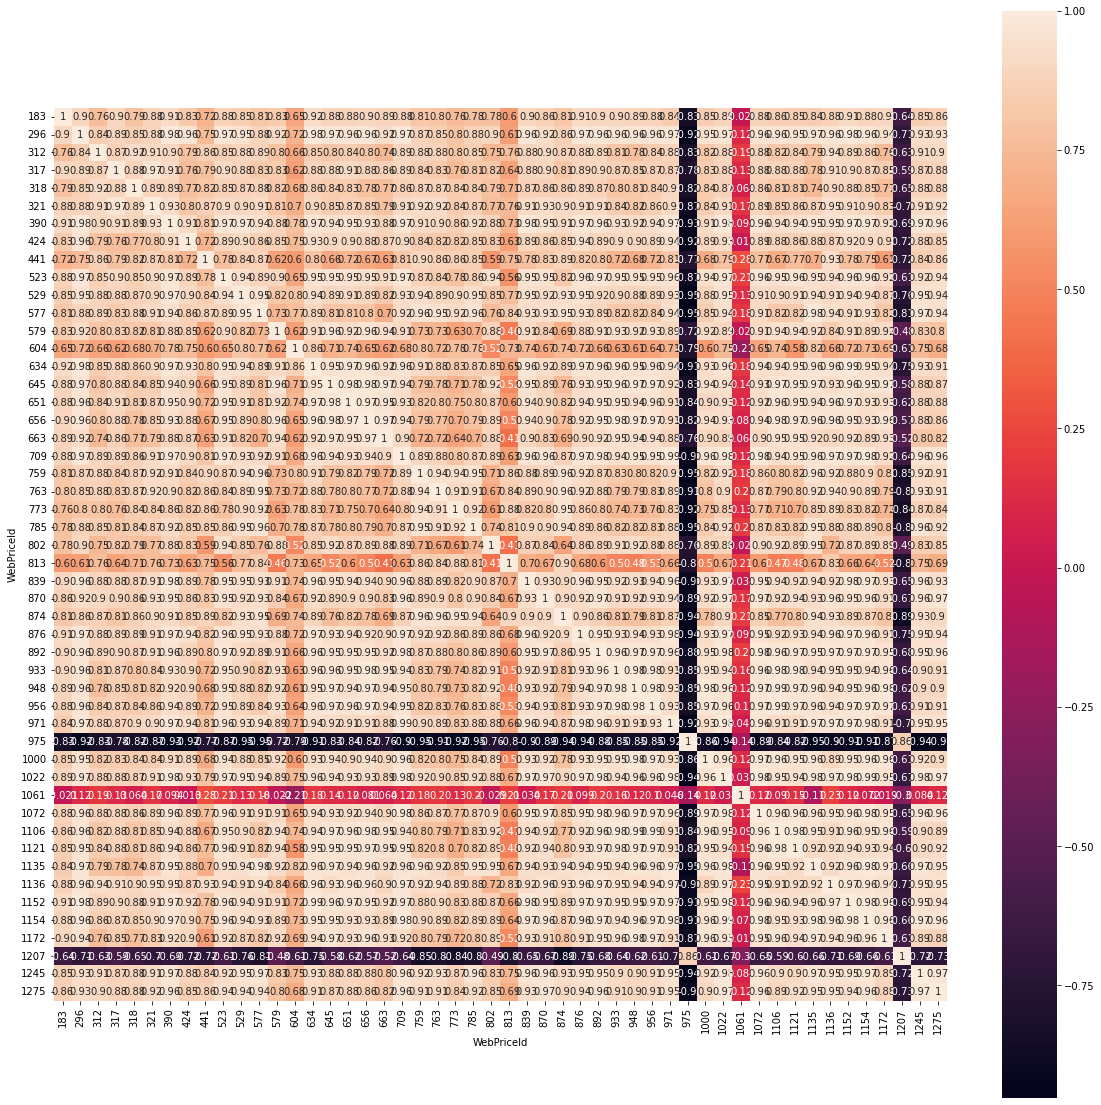

In [165]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(20,20)
sns.heatmap(X[X.columns.to_list()[:50]].corr(), square=True, annot=True)

In [68]:
x = month_change

In [69]:
x['month+year+group'] = x.index

In [72]:
x = x.replace(np.inf, np.nan).fillna(method='ffill').fillna(method='bfill')

In [73]:
x

WebPriceId,327872,5130755,5718255,5718254,5718256,5126210,5126211,5126207,5126213,5126208,5126212,5126209,3857827,3857794,3857805,3857833,3857842,3857832,311327,311324,3857839,3857825,3857845,3857795,3857790,3857810,3857797,3857813,3857798,3857824,3857846,3857838,3857811,3857828,3857831,3857815,3857816,3857814,2764922,3857812,3857803,2611186,4889546,3857841,2611201,2611401,2611046,4304186,2611049,2611048,...,2771724,46960,3237038,140949,2684979,3953530,2935011,3964603,158336,3568833,3568829,2934945,3587665,3401933,47072,47090,3235957,7697082,3236064,2935132,2684735,3236791,144803,4704177,4425836,2687678,2935242,2687662,3251942,3064316,4592065,6208455,46620,3064839,6206818,3065460,253456,4423304,3450861,2723469,6254795,6255528,4223531,3481,3529342,8080,3252164,3713063,2723856,month+year+group
month+year+group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5_2020_3,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,...,1.000000,1.0,1.0,1.000000,1.0,1.00000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.00000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.00000,1.0,1.00000,1.000000,1.0,5_2020_3
6_2020_1,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,...,1.000000,1.0,1.0,1.000000,1.0,1.00000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.00000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.00000,1.0,1.00000,1.000000,1.0,6_2020_1
6_2020_2,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,...,1.000000,1.0,1.0,1.000000,1.0,1.00000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.00000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.00000,1.0,1.00000,1.000000,1.0,6_2020_2
6_2020_3,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,...,1.000000,1.0,1.0,0.959960,1.0,1.00000,1.0,1.000000,0.807198,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.0,1.058673,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.00000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.00000,1.0,1.00000,1.000000,1.0,6_2020_3
7_2020_0,0.015262,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,...,1.000000,1.0,1.0,1.000000,1.0,1.00000,1.0,1.000000,1.015924,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.172722,1.0,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.00000,1.000000,1.211833,1.0,1.000000,1.000000,1.013353,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.00000,1.0,1.00000,1.000000,1.0,7_2020_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [130]:
x[x.columns.to_list()[81]]

month+year+group
10_2020_0    5279.0
10_2020_1    4674.0
10_2020_2    4674.0
10_2020_3    4674.0
10_2021_0    4674.0
              ...  
9_2020_3     5069.0
9_2021_0     5069.0
9_2021_1     5069.0
9_2021_2     5069.0
9_2021_3     5069.0
Name: 2812365, Length: 96, dtype: float64

In [82]:
def difference(data, feature):
    # assume data is already sorted
    return data[feature] - data['Total_Sales_dollars'].shift(1)

def difference_in_percentage(data, feature):
    # assume data is already sorted
    lag_by_1 = data[feature].shift(1)
    return (data[feature] - lag_by_1)/(lag_by_1)

def make_features(df, columns):
    final_table = None

    for column in columns:
        Train_Table = df[['month+year+group', column]].dropna().reset_index(drop=True)
        Train_Table.columns = ['month+year+group', 'Total_Sales_dollars']

        '''
        scaler = StandardScaler()
        values = Train_Table['Total_Sales_dollars'].values.reshape((len(Train_Table), 1))
        Train_Table['Total_Sales_dollars'] = scaler.fit_transform(values)
        '''

        # Train_Table['Total_Sales_dollars'] = (Train_Table['Total_Sales_dollars'].values - np.mean(Train_Table['Total_Sales_dollars'])) / np.std(Train_Table['Total_Sales_dollars'])

        # extracted_features = extract_features(Train_Table[['Total_Sales_dollars', 'month_num']], column_id="Total_Sales_dollars", column_sort="month_num")

        Train_Table['Total_Sales_Dollars_lag1'] = Train_Table['Total_Sales_dollars'].shift(1)

        Train_Table['Total_Sales_Dollar_MA2_lag1'] = Train_Table['Total_Sales_dollars'].rolling(2).mean().shift(1).reset_index(0,drop=True)

        try:
            Train_Table['Total_Sales_Dollar_Difference_lag1'] = difference(Train_Table,'Total_Sales_dollars').shift(1)
            Train_Table['Total_Sales_Dollar_Difference_in_Percent_Lag1'] = difference_in_percentage(Train_Table,'Total_Sales_dollars').shift(1)
        except Exception:
            continue

        Train_Table = Train_Table.fillna(0)

        for i in range(2, 24):
            Train_Table[f'TSd_{i}'] = Train_Table['Total_Sales_dollars'].shift(i)

        Train_Table = Train_Table.fillna(0)

        final_table = Train_Table if columns.index(column) == 0 else pd.concat([final_table, Train_Table])

    return final_table

In [ ]:
import xgboost as xgb
import catboost as cbm
from sklearn.metrics import mean_absolute_error

Train_Table = make_features(x.replace(np.inf, np.nan).fillna(method='ffill').fillna(method='bfill'), x.columns.to_list()[:-30000])

Table = Train_Table.reset_index(drop=True)

training_data, testing_data = train_test_split(Table.drop('month+year', axis=1), test_size=0.2, random_state=42, shuffle=True)
print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

x_train, y_train = training_data.drop("Total_Sales_dollars", axis=1), training_data['Total_Sales_dollars']
x_test, y_test   = testing_data.drop("Total_Sales_dollars", axis=1) , testing_data['Total_Sales_dollars']

In [ ]:
# model = xgb.XGBRegressor(random_state=42)
model = cbm.CatBoostRegressor(random_state=42, iterations=10000, eval_metric='MAE')
model.fit(x_train, y_train, eval_set=(x_test, y_test), early_stopping_rounds=1000, verbose=500)

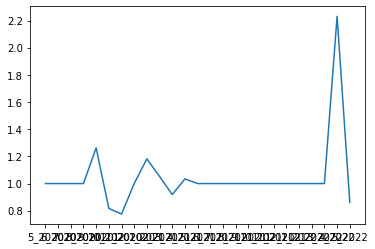

In [181]:
plt.plot(x[x.columns.to_list()[100]])

In [182]:
import pmdarima as pm

ARIMA_model = pm.auto_arima(x[x.columns.to_list()[81]].dropna(), 
                      start_p=2, 
                      start_q=2,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=True, # No Seasonality for standard ARIMA
                      trace=True, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

ARIMA_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-14.503, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-22.336, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=-27.798, Time=0.01 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=-26.973, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=-34.571, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=-32.970, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec

Best model:  ARIMA(2,2,1)(0,0,0)[0]          
Total fit time: 0.456 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   25
Model:               SARIMAX(2, 2, 1)   Log Likelihood                  21.285
Date:                Sat, 24 Sep 2022   AIC                            -34.571
Time:                        03:56:20   BIC                            -30.029
Sample:                             0   HQIC                           -33.429
                                 - 25                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5961      0.297     -2.009      0.045      -1.178      -0.015
ar.L2         -0.3576      0.619     -0.578      0.563      -1.571       0.855
ma.L1         -0.9879      4.281     -0.231      0.817      -9.378       7.402
sigma2         0.0075      0.030      0.253      0.800      -0.051       0.066
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                21.32
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                            -1.07
Prob(H) (two-sided):                  0.08   Kurtosis:                         7.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

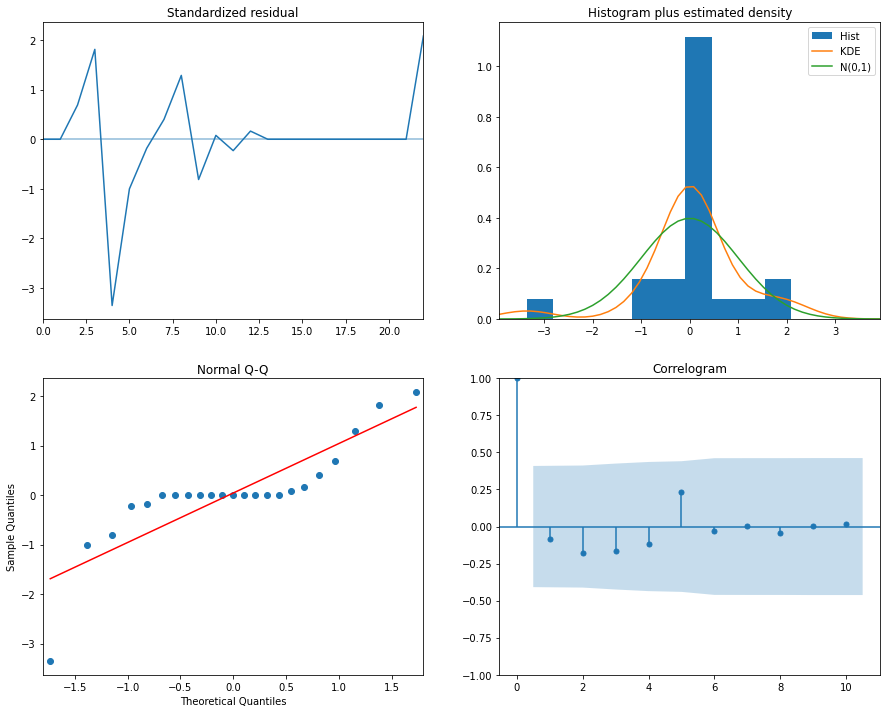

In [183]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

/Users/nikitaromanov/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


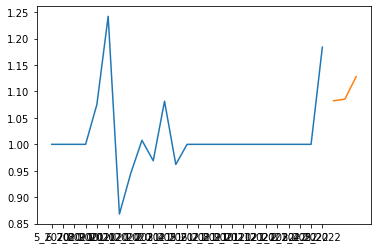

In [184]:
plt.plot(x[x.columns.to_list()[81]])
plt.plot(ARIMA_model.predict(3))

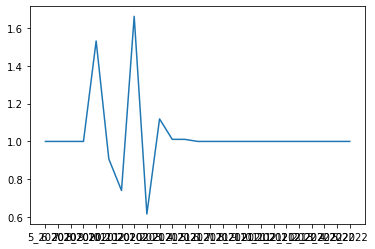

In [197]:
plt.plot(x[x.columns.to_list()[60]])

In [228]:
x

WebPriceId,327872,5130755,5718255,5718254,5718256,5126210,5126211,5126207,5126213,5126208,5126212,5126209,3857827,3857794,3857805,3857833,3857842,3857832,311327,311324,3857839,3857825,3857845,3857795,3857790,3857810,3857797,3857813,3857798,3857824,3857846,3857838,3857811,3857828,3857831,3857815,3857816,3857814,2764922,3857812,3857803,2611186,4889546,3857841,2611201,2611401,2611046,4304186,2611049,2611048,...,3804607,5108464,2776097,2879712,4134591,3249059,2969702,3249083,7423,6797050,2969736,3418643,5283394,3418661,10436749,3885775,2969731,4109838,3050227,2249422,3418688,3050264,4090333,7358835,2879762,3805182,2879756,2879727,7358847,4734654,4050976,4616943,4616941,3249087,4616940,5344508,7363446,8117184,7361946,8117185,160863,4616893,3418845,3904098,4617532,3249025,2969773,2181828,3418726,month+year
month+year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5_2020,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,...,1.0,1.000000,1.000000,1.00000,1.0,1.0,1.000000,1.00000,1.000000,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,1.00000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,5_2020
6_2020,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,...,1.0,1.000000,1.000000,1.00000,1.0,1.0,1.000000,1.00000,1.000000,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,1.00000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,6_2020
7_2020,0.046922,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.515152,1.262626,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,...,1.0,1.000000,1.000000,1.00000,1.0,1.0,1.000000,1.00000,0.943343,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,1.00000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,7_2020
8_2020,0.534667,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.830000,0.896000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,...,1.0,1.000000,1.000000,1.00000,1.0,1.0,1.000000,1.00000,1.070571,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,1.00000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.092928,1.0,1.0,1.0,1.

In [35]:
# получаем колонки - товары, предсказываем на месяц вперёд
def inference(df, up_to_date):
    preds = []
    for column in df.columns.to_list():
        ARIMA_model = pm.auto_arima(df[column].replace(np.inf, np.nan).dropna().reset_index(drop=True), 
                      start_p=2, 
                      start_q=2,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of sseries (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=True, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='ignore', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)
        # preds.append(ARIMA_model.predict(1).values[0])
        preds.append(ARIMA_model.predict(1).values[0])
        # print('preds: ', preds)
    return preds

In [36]:
x = x.loc[x.index.to_list()[:-4]]

In [226]:
x.index.to_list()[:-1]

['5_2020',
 '6_2020',
 '7_2020',
 '8_2020',
 '9_2020',
 '10_2020',
 '11_2020',
 '12_2020',
 '1_2021',
 '2_2021',
 '3_2021',
 '4_2021',
 '5_2021',
 '6_2021',
 '7_2021',
 '8_2021',
 '9_2021',
 '10_2021',
 '11_2021',
 '12_2021']

In [39]:
inference(x[x.columns.to_list()[:30]].loc[x.index.to_list()[:-1]], 1)

[-93.64221554872161,
 1.055273653396968,
 263.33054950280825,
 0.014078379100322724,
 441.331273482006,
 245.1855769996518,
 168.87618773480463,
 153.72813749478505,
 19.329835641159082,
 19.58818202337697,
 25.639530592088775,
 34.840043907603466,
 1.0714554425293166,
 1.0075990343859889,
 1.0,
 0.9369642475891894,
 0.8585585027877044,
 0.9985444746255112,
 1.0131520666312421,
 1.0353098466503348,
 0.969095933036936,
 1.013712332917754,
 1.0806273112652702,
 1.0197777679277003,
 0.9832402226401686,
 0.9999964252513526,
 1.0092190788268056,
 1.0,
 1.0049997738198102,
 1.004005020277691]

In [212]:
x.index.to_list()[:24]

['5_2020',
 '6_2020',
 '7_2020',
 '8_2020',
 '9_2020',
 '10_2020',
 '11_2020',
 '12_2020',
 '1_2021',
 '2_2021',
 '3_2021',
 '4_2021',
 '5_2021',
 '6_2021',
 '7_2021',
 '8_2021',
 '9_2021',
 '10_2021',
 '11_2021',
 '12_2021',
 '1_2022',
 '2_2022',
 '3_2022',
 '4_2022']

In [44]:
x.loc[x.index.to_list()[-1]][:30]

WebPriceId
327872            1.0
5130755           1.0
5718255        1000.0
5718254           inf
5718256    271.428576
              ...    
3857810           1.0
3857797           1.0
3857813           1.0
3857798           1.0
3857824           1.0
Name: 1_2022, Length: 30, dtype: object

In [229]:
inference(x[x.columns.to_list()[:30]].loc[x.index.to_list()[:-1]], 1)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=393.723, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=385.078, Time=0.00 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=381.998, Time=0.01 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=381.189, Time=0.01 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=378.224, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=380.224, Time=0.01 sec

Best model:  ARIMA(2,2,1)(0,0,0)[0]          
Total fit time: 0.335 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)

[-93.64221554872161,
 1.055273653396968,
 263.33054950280825,
 0.014078379100322724,
 441.331273482006,
 245.1855769996518,
 168.87618773480463,
 153.72813749478505,
 19.329835641159082,
 19.58818202337697,
 25.639530592088775,
 34.840043907603466,
 1.0714554425293166,
 1.0075990343859889,
 1.0,
 0.9369642475891894,
 0.8585585027877044,
 0.9985444746255112,
 1.0131520666312421,
 1.0353098466503348,
 0.969095933036936,
 1.013712332917754,
 1.0806273112652702,
 1.0197777679277003,
 0.9832402226401686,
 0.9999964252513526,
 1.0092190788268056,
 1.0,
 1.0049997738198102,
 1.004005020277691]

In [43]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(x.loc[x.index.to_list()[-1]][:30].replace(np.inf, np.nan).fillna(method='ffill').fillna(method='bfill'), inference(x[x.columns.to_list()[:30]].loc[x.index.to_list()[:-1]], 1))

88.73188370046712

In [113]:
pd.to_datetime(x.index.str.replace('_', '/')).sort_values()

DatetimeIndex(['2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
               '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
               '2022-05-01'],
              dtype='datetime64[ns]', name='month+year', freq=None)

In [ ]:
# получаем колонки - товары, предсказываем на месяц вперёд
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer

def inference(df, up_to_date):
    preds = []
    start, end = pd.to_datetime(df.index.str.replace('_', '/')).sort_values()[[0, -1]]
    df.index = pd.to_datetime(df.index.str.replace('_', '/')).sort_values()
    for column in df.columns.to_list():
        training_data = ListDataset(
        [{'start':start,
        'target': df[column].loc[:end]}], freq = 'M')
        # print('preds: ', preds)

        estimator = DeepAREstimator(freq='M',prediction_lenght = 1)
        trainer = Trainer(epochs=20)

        predictor = Estimator.train(training_data=training_data)

    return preds

In [ ]:
inference(x[x.columns.to_list()[:10]], 1)

In [ ]:
from gluonts.dataset.common import ListDataset

training_data = ListDataset(
[{'start':pd.to_datetime(x.index.str.replace('_', '/')).sort_values()[0], 
'target': x[327872][:'2022-05-01']}], freq = 'M')

In [ ]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer

estimator = DeepAREstimator(freq='M',prediction_lenght = 1)
trainer = Trainer(epochs=20)

predictor = Estimator.train(training_data=training_data)

In [77]:
x[groups[3]].transpose().mean()

month+year+group
5_2020_3    1.000000
6_2020_1    1.000000
6_2020_2    1.000000
6_2020_3    1.000000
7_2020_0    1.001758
              ...   
4_2022_3    1.041133
5_2022_0    0.967511
5_2022_3    1.044223
5_2022_1    1.036778
5_2022_2    0.985671
Length: 96, dtype: float64

In [87]:
group_table = pd.DataFrame(index=x.index)
for i in range(0, 5):
    group_table[str(i)] = x[groups[i]].transpose().mean()
group_table['month+year+group'] = group_table.index
group_table

,0,1,2,3,4,month+year+group
month+year+group,,,,,,
5_2020_3,1.000000,1.000000,0.999927,1.000000,1.000000,5_2020_3
6_2020_1,1.000000,1.000000,0.999927,1.000000,1.000000,6_2020_1
6_2020_2,1.000000,1.000000,0.999927,1.000000,1.000000,6_2020_2
6_2020_3,0.997959,0.999915,0.999927,1.000000,1.000000,6_2020_3
7_2020_0,1.079527,1.018317,1.016893,1.001758,0.990153,7_2020_0
...,...,...,...,...,...,...
4_2022_3,1.003728,0.999692,0.999047,1.041133,0.994524,4_2022_3
5_2022_0,1.009329,1.000349,1.001992,0.967511,0.993617,5_2022_0
5_2022_3,1.010070,1.000686,1.001930,1.044223,0.995580,5_2022_3


In [88]:
import xgboost as xgb
import catboost as cbm
from sklearn.metrics import mean_absolute_error

Train_Table = make_features(group_table, group_table.columns.to_list())

Table = Train_Table.reset_index(drop=True)

training_data, testing_data = train_test_split(Table.drop('month+year+group', axis=1), test_size=0.2, random_state=42, shuffle=True)
print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

x_train, y_train = training_data.drop("Total_Sales_dollars", axis=1), training_data['Total_Sales_dollars']
x_test, y_test   = testing_data.drop("Total_Sales_dollars", axis=1) , testing_data['Total_Sales_dollars']

No. of training examples: 384
No. of testing examples: 96


In [93]:
# model = xgb.XGBRegressor(random_state=42)
model = cbm.CatBoostRegressor(random_state=42, iterations=10000, eval_metric='MAE')
model.fit(x_train, y_train, eval_set=(x_test, y_test), early_stopping_rounds=5000, verbose=500)

Learning rate set to 0.010756
0:	learn: 8.1573660	test: 4.9389706	best: 4.9389706 (0)	total: 6.21ms	remaining: 1m 2s
500:	learn: 2.0833591	test: 3.5323128	best: 2.9079987 (239)	total: 662ms	remaining: 12.6s
1000:	learn: 1.0672318	test: 4.4337842	best: 2.9079987 (239)	total: 1.3s	remaining: 11.7s
1500:	learn: 0.7468389	test: 4.8190993	best: 2.9079987 (239)	total: 1.94s	remaining: 11s
2000:	learn: 0.5544260	test: 4.8395555	best: 2.9079987 (239)	total: 2.57s	remaining: 10.3s
2500:	learn: 0.3894913	test: 4.7661983	best: 2.9079987 (239)	total: 3.22s	remaining: 9.64s
3000:	learn: 0.2660616	test: 4.6833935	best: 2.9079987 (239)	total: 3.86s	remaining: 9s
3500:	learn: 0.1755366	test: 4.6497664	best: 2.9079987 (239)	total: 4.52s	remaining: 8.4s
4000:	learn: 0.1189615	test: 4.6364478	best: 2.9079987 (239)	total: 5.17s	remaining: 7.76s
4500:	learn: 0.0815682	test: 4.6317818	best: 2.9079987 (239)	total: 5.81s	remaining: 7.1s
5000:	learn: 0.0576016	test: 4.6280147	best: 2.9079987 (239)	total: 6.45s

<AxesSubplot:>

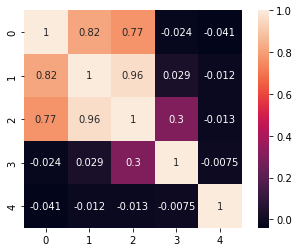

In [94]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(20,20)
sns.heatmap(group_table.corr(), square=True, annot=True)